# READ ME

#### This notebook is implemeted in a repository in github with input and output folders.
#### It has 2 parts:
##### > Part 1: Pre-defined funtions for each technique.
##### > Part 2: Execution of model pipelines, here users can modify which combination of techniques they want to run. The scores will be printed as a csv in output folders. 

# PART 1: FUNCTIONS

# Import library

In [1]:
#importing libraries
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize,ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from boruta import BorutaPy
from BorutaShap import BorutaShap
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

from collections import Counter
from sklearn.svm import SVC,LinearSVC

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, log_loss, cohen_kappa_score,fbeta_score, make_scorer,matthews_corrcoef
from sklearn.model_selection import cross_validate

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from skopt import BayesSearchCV
from skopt.plots import plot_objective, plot_histogram
from skopt.space import Real, Categorical, Integer
from sklearn.pipeline import Pipeline

# Read df

In [2]:
#this function is to read, transform and join 2 data frame

def read_features():
    path = 'input/secom.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['feature_'+str(x+1) for x in range(len(df.columns))]
    return df


def read_target():
    path = 'input/secom_labels.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['status','timestamp']
    df['timestamp'] = pd.to_datetime(df['timestamp'],dayfirst=True)
    return df


# Remove duplicated columns

In [3]:
#find the duplicated features (columns)
def remove_duplicated_columns(df):
    list_duplicate = []
    to_remove = []
    for i in range(0, len(df.columns)):
        l = []
        for j in range(i+1,len(df.columns)):
            if df.iloc[:,i].equals(df.iloc[:,j]) == True:
                if j not in list_duplicate:
                    l.append(j)
                    to_remove.append('feature_'+str(j+1))
                list_duplicate.append(i)
                list_duplicate.append(j)

    return df.drop(columns=to_remove, axis = 1)

# X = remove_duplicated_columns(X)
# X.shape


# Remove columns with Constant volatility (std=0)

In [4]:
def remove_constant_volatility(df):
    df_EDA= df.describe().T
    df_EDA= df_EDA[df_EDA["std"] == 0]
    df = df.drop(axis=1, columns=df_EDA.index)
    return df

# X = remove_constant_volatility(X)
# X.shape

# Remove columns with high %Missing values

In [5]:
def remove_cols_with_high_pct_null(df, null_threshold):
    list_column_with_pct_null = pd.concat([df.isnull().sum(), df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    list_column_with_pct_null= list_column_with_pct_null[list_column_with_pct_null["Percentage (%)"] >= null_threshold]
    df = df.drop(axis=1, columns=list_column_with_pct_null.index)
    return df

# X = remove_cols_with_high_pct_null(X, 0.8)
# X.shape

# Split data

In [7]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1,stratify=y)

# Outlier treatment

In [6]:
#how = ['NaN', '3s' ,'nothing']
def replace_outlier(df, how):
    for col in df:
        ll_col = df[col].mean() - 3 * df[col].std()
        ul_col = df[col].mean() + 3 * df[col].std()
        if how == 'NaN':
            df[col] = np.where(df[col]>ul_col,np.NaN,np.where(df[col]<ll_col,np.NaN,df[col]))
        elif how == '3s':
            df[col] = np.where(df[col]>ul_col,ul_col,np.where(df[col]<ll_col,ll_col,df[col]))
    return df

# Missing value Imputation

In [7]:
#which_weights = ['distance','uniform']

def impute_null_with_knn(X_train, X_test, which_weights):
    #First scale the data 
    scaler = MinMaxScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns= X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns= X_test.columns)

    knn = KNNImputer(n_neighbors=5, weights=which_weights) #check this neighbors = 5

    X_train = pd.DataFrame(knn.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(knn.transform(X_test), columns=X_test.columns)
    
    X_train = pd.DataFrame(scaler.inverse_transform(X_train), columns= X_train.columns)
    X_test = pd.DataFrame(scaler.inverse_transform(X_test), columns= X_test.columns)
    return X_train, X_test

#X_train = impute_null_with_knn(X_train)

# Feature Selection

In [9]:
#This is BorutaShap with TENTATIVE features

#list_method=['shap','gini']

def BorutaShap_FS (X, y,method_option) :
    #modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, class_weight='balanced_subsample', max_depth=5, random_state=100)
    modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, max_depth=5, random_state=100)

    # define model for resp. classifier
    modelshap.fit(X,y)
    feature_names = np.array(X.columns)
    # define Boruta Sahp feature selection method
    feature_selector = BorutaShap(model=modelshap,
                              importance_measure=method_option,
                              classification=True)  # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = False,random_state=100)  
    #feature_selector.plot(which_features='accepted',figsize=(20,10))
    tentative=X.loc[:,feature_selector.tentative]
    selected=feature_selector.Subset()
    selten=pd.concat([selected,tentative],axis=1)
    # call transform() on X to filter it down to selected features
    return  selten

# Balancing

In [10]:
def sampling(X_train, y_train, sampler):
    
    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)    
    
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100, shrinkage=1)

    #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100)
    

    #SMOTTEENN
    if sampler == 'SMOTEENN' :
        sampler = SMOTEENN(random_state=100)
        
        
    #Random under Sampling
    if sampler == "randomunder":
        sampler = RandomUnderSampler(random_state=100)

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    #counter = Counter(y_resampled)
    #print(counter)
    
    return X_resampled, y_resampled

# X_train, y_train = sampling(X_train, y_train,'SMOTE')
# X_train.shape

# Model

# SVM with 3s, knn,BoS__shap, SMOTEENN 

In [14]:
X = read_features()
y = read_target().iloc[:,0]

result = []

#step 1:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify=y)

# # step 2:
X_train = remove_duplicated_columns(X_train)
# #step 3:
X_train = remove_constant_volatility(X_train)
# #step 4:
X_train = remove_cols_with_high_pct_null(X_train, 0.8) #this can be in the loop too, may be later
# #step 5: remove the same columns from step 2-4 TRAIN_TEST split
X_test = X_test.loc[:,X_train.columns]

fast_track_cols = X_test.columns

X_train = X_train.loc[:, fast_track_cols]
X_test = X_test.loc[:, fast_track_cols]

X_train_temp = X_train
X_test_temp = X_test
y_train_temp = y_train
y_test_temp = y_test
X_train_temp = replace_outlier(X_train_temp, '3s')
X_test_temp = replace_outlier(X_test_temp, '3s')
X_train_temp, X_test_temp = impute_null_with_knn(X_train_temp, X_test_temp, 'distance')
X_train_temp = BorutaShap_FS(X_train_temp, y_train_temp, 'shap')
X_test_temp = X_test_temp.loc[:,X_train_temp.columns]
X_train_temp, y_train_temp = sampling(X_train_temp, y_train_temp, 'SMOTEENN')

100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


# SVM Model grid search

In [15]:
np.random.seed(0) ; np.random.rand(4);

In [16]:
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [0.001, 0.01, 0.1,1], "C": [0.1,1, 100, 1000,10000]},
    {"kernel": ["linear"], "C": [0.1,1, 100, 1000,10000]},
    {"kernel": ["poly"], "gamma": [0.001, 0.01, 0.1,1], "C": [0.1,1, 100, 1000,10000], "degree" : [1,2,3,4,5]}
]
hp = [
    {"kernel": ["rbf"], "gamma": [1e-5,1e-4,0.001, 0.01, 0.1,1,10,100], "C": [0.01,0.1,1, 100, 1000,10000,1e5,1e6]},
    {"kernel": ["linear"], "C": [0.01,0.1,1, 100, 1000,10000,1e5,1e6]},
    {"kernel": ["poly"], "gamma": [1e-5,1e-4,0.001, 0.01, 0.1,1,10,100], "C": [0.01,0.1,1, 100, 1000,10000,1e5,1e6], "degree" : [1,2,3]}
]
poly_param= [
    {"kernel": ["poly"], "gamma": [0.001, 0.01, 0.1,1], "C": [1, 100, 1000,10000], "degree" : [1,2,3]}
]

## make customized scorer

In [19]:
def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1]}
def tp_scorer(clf,X,y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tp=cm[1, 1]
    return tp
def tn_scorer(clf,X,y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn=cm[0, 0]
    return tn
def fp_scorer(clf,X,y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    fp=cm[0, 1]
    return fp
def fn_scorer(clf,X,y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    fn=cm[1, 0]
    return fn
def mcc_score(y_true, y_pred):
    mcc = matthews_corrcoef(y_true, y_pred)
    return mcc
def tpr_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tprate = float(cm[1][1])/np.sum(cm[1])
    return tprate
def fpr_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fprate = float(cm[1][0])/np.sum(cm[0])
    return fprate
def cost_wafer(y_true,y_pred):
    cm = confusion_matrix(y_true, y_pred)
    FP=cm[0][1]
    FN=cm[1][0]
    cost_wafer= (1*FP) + (10*FN)
    return cost_wafer

In [20]:
scorer={#'cf_scorer': make_scorer(confusion_matrix_scorer),
        'acc' : 'accuracy',
        'rec' : 'recall',
        'pre': 'precision',
        'f1' : 'f1',
        #'fbeta' : make_scorer(fbeta_score, beta=3),
        'mcc' : make_scorer(mcc_score,greater_is_better=True),
        'roc' :'roc_auc',
        'cost_wafer': make_scorer(cost_wafer,greater_is_better=False)
        #'tpr' : make_scorer(tpr_score,greater_is_better=True),
        #'fpr' : make_scorer(fpr_score,greater_is_better=False)
         }

In [21]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=tuned_parameters, cv=cv, scoring=scorer ,refit='mcc',verbose=4,return_train_score=True)

In [22]:
scaler = MinMaxScaler()
X_train_temp_scaled= pd.DataFrame(scaler.fit_transform(X_train_temp), columns=X_train_temp.columns)
grid.fit(X_train_temp_scaled, y_train_temp)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV 1/5] END C=0.1, gamma=0.001, kernel=rbf; acc: (train=0.574, test=0.575) cost_wafer: (train=-604.000, test=-151.000) f1: (train=0.729, test=0.730) mcc: (train=0.000, test=0.000) pre: (train=0.574, test=0.575) rec: (train=1.000, test=1.000) roc: (train=0.851, test=0.847) total time=   0.1s
[CV 2/5] END C=0.1, gamma=0.001, kernel=rbf; acc: (train=0.574, test=0.575) cost_wafer: (train=-604.000, test=-151.000) f1: (train=0.729, test=0.730) mcc: (train=0.000, test=0.000) pre: (train=0.574, test=0.575) rec: (train=1.000, test=1.000) roc: (train=0.853, test=0.836) total time=   0.0s
[CV 3/5] END C=0.1, gamma=0.001, kernel=rbf; acc: (train=0.574, test=0.575) cost_wafer: (train=-604.000, test=-151.000) f1: (train=0.729, test=0.730) mcc: (train=0.000, test=0.000) pre: (train=0.574, test=0.575) rec: (train=1.000, test=1.000) roc: (train=0.851, test=0.843) total time=   0.0s
[CV 4/5] END C=0.1, gamma=0.001, kernel=rbf; acc: (train=0

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(),
             param_grid=[{'C': [0.1, 1, 100, 1000, 10000],
                          'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['rbf']},
                         {'C': [0.1, 1, 100, 1000, 10000],
                          'kernel': ['linear']},
                         {'C': [0.1, 1, 100, 1000, 10000],
                          'degree': [1, 2, 3, 4, 5],
                          'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['poly']}],
             refit='mcc', return_train_score=True,
             scoring={'acc': 'accuracy',
                      'cost_wafer': make_scorer(cost_wafer, greater_is_better=False),
                      'f1': 'f1', 'mcc': make_scorer(mcc_score),
                      'pre': 'precision', 'rec': 'recall', 'roc': 'roc_auc'},
             verbose=4)

In [23]:
grid.best_estimator_

SVC(C=100, gamma=1)

In [24]:
cv_results=pd.DataFrame.from_dict(grid.cv_results_)

In [25]:
cv_results.to_csv('complete_run.csv')

## Visualise svm hyperparams

### Visualizing correlation range for gamma and C

In [ ]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid_vis123 = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid_vis123.fit(X, y)

In [ ]:
scores1 = grid_vis123.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))

In [93]:
pd.DataFrame.from_dict(scores1)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.574648,0.574648,0.574648,0.574648,0.574648,0.574648,0.574648,0.574648,0.574648,0.574648,0.574648,0.574648,0.574648
1,0.574648,0.574648,0.574648,0.574648,0.574648,0.574648,0.574648,0.574648,0.627042,0.796620,0.722817,0.574648,0.574648
2,0.574648,0.574648,0.574648,0.574648,0.574648,0.574648,0.574648,0.640000,0.797183,0.859718,0.975211,0.891268,0.574648
3,0.574648,0.574648,0.574648,0.574648,0.574648,0.574648,0.643380,0.791549,0.824225,0.916620,0.976901,0.899155,0.574648
4,0.574648,0.574648,0.574648,0.574648,0.574648,0.643944,0.792113,0.798310,0.865915,0.949859,0.976901,0.899155,0.574648
5,0.574648,0.574648,0.574648,0.574648,0.643944,0.792113,0.793239,0.833803,0.889577,0.949296,0.976901,0.899155,0.574648
6,0.574648,0.574648,0.574648,0.643380,0.790986,0.790986,0.799437,0.865915,0.919437,0.947606,0.976901,0.899155,0.574648
7,0.574648,0.574648,0.653521,0.793239,0.788169,0.797183,0.835493,0.884507,0.936338,0.947606,0.976901,0.899155,0.574648
8,0.574648,0.701408,0.789296,0.793239,0.791549,0.804507,0.870986,0.902535,0.936901,0.947606,0.976901,0.899155,0.574648
9,0.690141,0.609014,0.709859,0.791549,0.785915,0.811268,0.872113,0.904789,0.936901,0.947606,0.976901,0.899155,0.574648


In [95]:
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

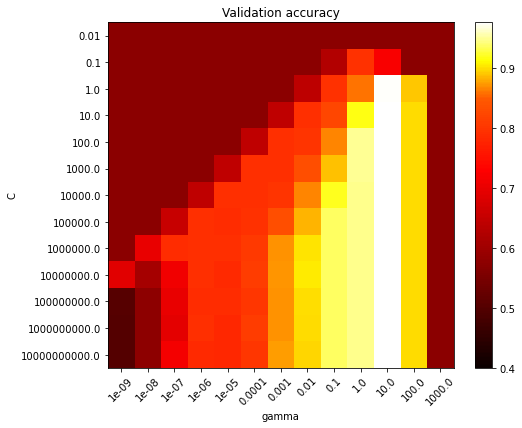

In [116]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores1,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.4,midpoint=0.85),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation accuracy")
plt.show()
#good model score found between the Gamma ranges of 0.01 to 10 and C values of 100 to 10^5
# when gamma is higher , or gamma is 10 no value of C can control overfitting 
# higher values of C are not prefereable because they increase risk of overfitting and take more time to fit the model
# that for some intermediate values of gamma we get equally performing models when C becomes very large, so smaller values of C can be used to keep model fitting time reasonable 

#10000,0.1
#10000,0.01
#100,1
#1000,1

### kernel Performance over CV folds
https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html

In [26]:
results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values(by=["rank_test_acc"])
#results_df = results_df.set_index(
   # results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
#)
results_df = results_df.set_index(results_df['param_kernel'])
results_df[["param_kernel", "rank_test_acc", "mean_test_acc", "std_test_acc","rank_test_pre", "mean_test_pre", "std_test_pre","rank_test_rec", "mean_test_rec", "std_test_rec",
"rank_test_mcc", "mean_test_mcc", "std_test_mcc","rank_test_f1", "mean_test_f1", "std_test_f1","rank_test_roc", "mean_test_roc", "std_test_roc"]]

,param_kernel,rank_test_acc,mean_test_acc,std_test_acc,rank_test_pre,mean_test_pre,std_test_pre,rank_test_rec,mean_test_rec,std_test_rec,rank_test_mcc,mean_test_mcc,std_test_mcc,rank_test_f1,mean_test_f1,std_test_f1,rank_test_roc,mean_test_roc,std_test_roc
param_kernel,,,,,,,,,,,,,,,,,,,
rbf,rbf,1,0.949859,0.006274,7,0.920581,0.008665,49,0.999020,0.001961,1,0.900580,0.012278,1,0.958179,0.005072,1,0.977555,0.004536
rbf,rbf,2,0.949296,0.004714,1,0.927524,0.009273,52,0.989216,0.007204,2,0.898044,0.009391,2,0.957319,0.003814,2,0.975971,0.007318
poly,poly,3,0.947606,0.006570,2,0.927285,0.009072,54,0.986275,0.006503,4,0.894273,0.013277,4,0.955833,0.005404,4,0.970212,0.006812
rbf,rbf,3,0.947606,0.003821,6,0.925712,0.007025,53,0.988235,0.008547,3,0.894601,0.008111,3,0.955900,0.003226,3,0.975282,0.006438
poly,poly,5,0.942535,0.006324,8,0.919668,0.009365,54,0.986275,0.005717,5,0.884335,0.012641,5,0.951769,0.005126,6,0.967926,0.009692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
poly,poly,80,0.574648,0.000000,80,0.574648,0.000000,1,1.000000,0.000000,80,0.000000,0.000000,80,0.729875,0.000000,82,0.851454,0.014168
poly,poly,80,0.574648,0.000000,80,0.574648,0.000000,1,1.000000,0.000000,80,0.000000,0.000000,80,0.729875,0.000000,75,0.853240,0.013808
poly,poly,80,0.574648,0.000000,80,0.574648,0.000000,1,1.000000,0.000000,80,0.000000,0.000000,80,0.729875,0.000000,88,0.851331,0.014113


In [27]:
model_scores = results_df.filter(regex=r"split\d*_test_acc")
model_pre= results_df.filter(regex=r"split\d*_test_pre")
model_rec= results_df.filter(regex=r"split\d*_test_rec")
model_f1= results_df.filter(regex=r"split\d*_test_f1")
model_mcc= results_df.filter(regex=r"split\d*_test_mcc")
model_roc= results_df.filter(regex=r"split\d*_test_roc")

findfont: Font family ['CMU Sans Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['CMU Sans Serif'] not found. Falling back to DejaVu Sans.


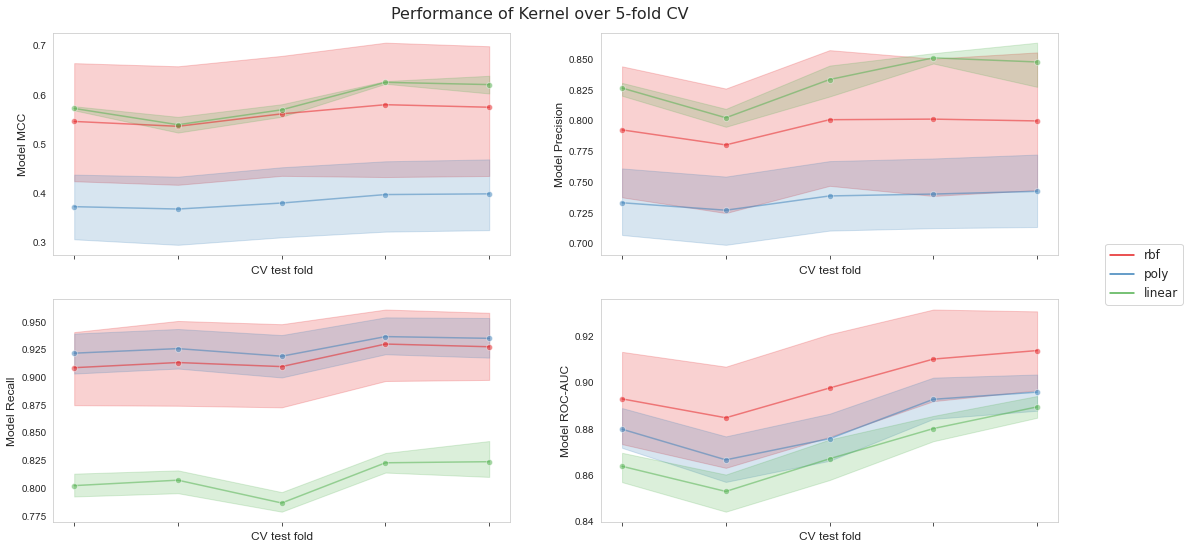

In [28]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig, axes = plt.subplots(
                     ncols=2,
                     nrows=2,
                     figsize=(18, 9))
mx, px, rx, ax = axes.flatten()
#mcc 
sns.set(style="whitegrid", font="CMU Sans Serif" )
mx=sns.lineplot(ax=axes[0, 0],
    data=model_mcc.transpose().iloc[:30],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    )
mx.get_legend().remove()
mx.set_xlabel("CV test fold", size=12, labelpad=10)
mx.set_ylabel("Model MCC", size=12)
mx.tick_params(bottom=True, labelbottom=False)
#precision
sns.set(style="whitegrid", font="CMU Sans Serif" )
px=sns.lineplot(ax=axes[0, 1],
    data=model_pre.transpose().iloc[:30],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    )
px.get_legend().remove()
px.set_xlabel("CV test fold", size=12, labelpad=10)
px.set_ylabel("Model Precision", size=12)
px.tick_params(bottom=True, labelbottom=False)
#recall
sns.set(style="whitegrid", font="CMU Sans Serif" )
rx=sns.lineplot(ax=axes[1, 0],
    data=model_rec.transpose().iloc[:30],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    )
rx.get_legend().remove()
rx.set_xlabel("CV test fold", size=12, labelpad=10)
rx.set_ylabel("Model Recall", size=12)
rx.tick_params(bottom=True, labelbottom=False)
#roc
sns.set(style="whitegrid", font="CMU Sans Serif" )
ax=sns.lineplot(ax=axes[1, 1],
    data=model_roc.transpose().iloc[:30],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    )
ax.get_legend().remove()
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model ROC-AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
handles, labels = mx.get_legend_handles_labels()
fig.legend(handles,['rbf','poly','linear'] ,loc='center right', fontsize='medium')
fig.suptitle("Performance of Kernel over 5-fold CV", fontsize=16,y=0.92)

plt.show()

### 3D plot gamma vs Cost vs Precision/Recall

No handles with labels found to put in legend.
findfont: Font family ['CMU Sans Serif'] not found. Falling back to DejaVu Sans.


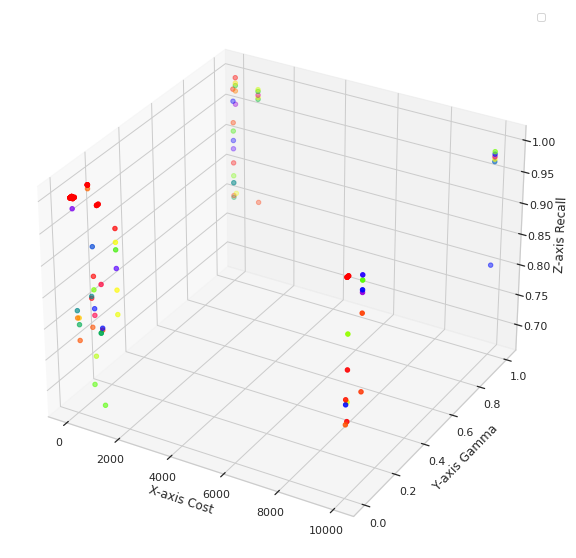

In [29]:
fig = plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 12})
vx = fig.add_subplot(projection='3d')

x,y,z = results_df.param_C ,results_df.param_gamma,results_df.mean_test_rec
vx.set_xlabel('X-axis Cost')
vx.set_ylabel('Y-axis Gamma')
vx.set_zlabel('Z-axis Recall')


# ax.plot(x, y, '+', markersize=.2, color='r', zdir='z', zs=-2.)
# ax.plot(x, z, '+', markersize=.2, color='g', zdir='y', zs=2.)
# ax.plot(y, z, '+', markersize=.2, color='b', zdir='x', zs=-2.)


vx.scatter(x,y,z,cmap='prism',c=results_df.rank_test_rec,marker='o')
#green = NN, red=RF, yellow=LR
vx.legend()
plt.show()

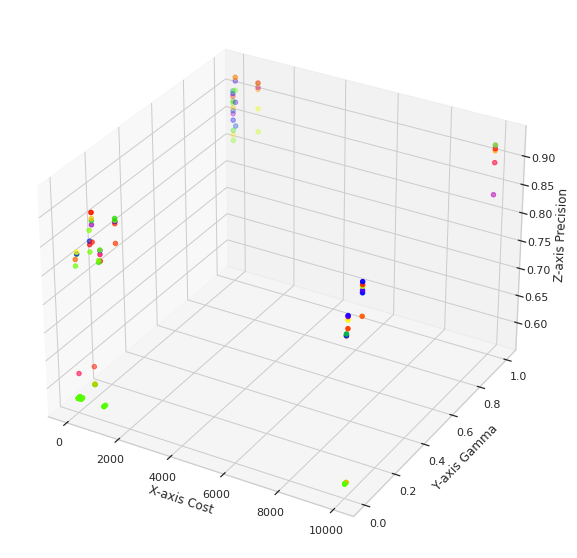

In [30]:
fig = plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 12})
vx = fig.add_subplot(projection='3d')

x,y,z = results_df.param_C, results_df.param_gamma,results_df.mean_test_pre
vx.set_xlabel('X-axis Cost')
vx.set_ylabel('Y-axis Gamma')
vx.set_zlabel('Z-axis Precision')


# ax.plot(x, y, '+', markersize=.2, color='r', zdir='z', zs=-2.)
# ax.plot(x, z, '+', markersize=.2, color='g', zdir='y', zs=2.)
# ax.plot(y, z, '+', markersize=.2, color='b', zdir='x', zs=-2.)


vx.scatter(x,y,z,cmap='prism',c=results_df.rank_test_pre, marker='o')
#green = NN, red=RF, yellow=LR
vx.get_legend()
plt.show()

### 2D plot for scores , with different gamma and C values

In [32]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2,met):

    scores_mean = cv_results['mean_test_'+met]

    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_'+met]

    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores

    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)

    for idx, val in enumerate(grid_param_2):

        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')

    ax.set_xlabel(name_param_1, fontsize=16)

    ax.set_ylabel('CV Average '+met, fontsize=16)

    ax.legend(loc="best", fontsize=15)

    ax.grid('on')

In [35]:
param_gamma=[0.001, 0.01, 0.1,1,10,100]
param_C=[0.01,0.1,1, 100, 1000,10000]
paramforvis = dict(gamma=param_gamma, C=param_C)

gridforvis = GridSearchCV(SVC(),paramforvis,scoring=scorer,refit='mcc', cv=cv)

gridforvis.fit(X_train_temp_scaled, y_train_temp)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 100, 1000, 10000],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             refit='mcc',
             scoring={'acc': 'accuracy',
                      'cost_wafer': make_scorer(cost_wafer, greater_is_better=False),
                      'f1': 'f1', 'mcc': make_scorer(mcc_score),
                      'pre': 'precision', 'rec': 'recall', 'roc': 'roc_auc'})

findfont: Font family ['CMU Sans Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['CMU Sans Serif'] not found. Falling back to DejaVu Sans.


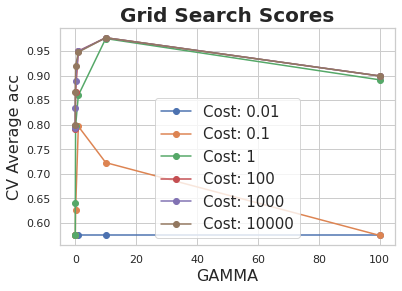

In [36]:
plot_grid_search(gridforvis.cv_results_, param_gamma, param_C, 'GAMMA', 'Cost','acc')

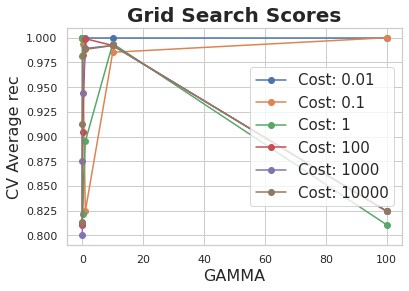

In [37]:
plot_grid_search(gridforvis.cv_results_, param_gamma, param_C, 'GAMMA', 'Cost','rec')

## run model svm and print all socres and cf

In [43]:
def run_model_svm(X_train, y_train, X_test, y_test,ker,ga,co,degree):
    scaler=MinMaxScaler()
    X_train_scaled= pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled= pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    if ker=='linear':
        model= SVC(kernel='linear',C=co)
    if ker=='rbf':
        model= SVC(kernel=ker,gamma=ga,C=co) 
    if ker=='poly':
        model= SVC(kernel=ker,gamma=ga,C=co,degree=degree) 
    
    model.fit(X_train_scaled,y_train)


    #For TEST SPLIT
    y_pred= model.predict(X_test_scaled)
    cf_matrix = confusion_matrix(y_test, y_pred)
    accuracy= accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred) ##
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = cf_matrix[1][1] / ( cf_matrix[1][1] + cf_matrix[1][0] )
    auc = roc_auc_score(y_test, y_pred)
    type_1_error_FP = cf_matrix[0][1]
    type_2_error_FN = cf_matrix[1][0]
    log_loss_ = log_loss(y_test, y_pred)
    cohen_kappa_score_ = cohen_kappa_score(y_test, y_pred)
    mcc= matthews_corrcoef(y_test, y_pred)
    cost_wafer= 1*type_1_error_FP + 10*type_2_error_FN
    #Note by default 1 is the positive label. Therefore, -1 is negative
    #bad waffe -> 2 line of matrix -> POSITIVE -> data = -1

    #For TRAIN SPLIT
    y_pred_train= model.predict(X_train_scaled)
    cf_matrix_train = confusion_matrix(y_train, y_pred_train)
    accuracy_train= accuracy_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train) ##
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    specificity_train = cf_matrix_train[1][1] / ( cf_matrix_train[1][1] + cf_matrix_train[1][0] )
    auc_train = roc_auc_score(y_train, y_pred_train)
    type_1_error_FP_train = cf_matrix_train[0][1]
    type_2_error_FN_train = cf_matrix_train[1][0]
    mcc_train= matthews_corrcoef(y_train, y_pred_train)
    cost_wafer_train= 1*type_1_error_FP_train + 10*type_2_error_FN_train




    return cf_matrix, accuracy, f1, precision, recall, mcc, type_1_error_FP, type_2_error_FN, cost_wafer,auc,log_loss_,cohen_kappa_score_, cf_matrix_train, accuracy_train, f1_train, precision_train, recall_train, mcc_train, type_1_error_FP_train, type_2_error_FN_train, cost_wafer_train,auc_train


In [42]:
#ker=['linear','rbf','poly']
ker=['linear','rbf','poly']
ga=[0.001,0.01,0.1,1]
co=[0.01,1,100,1000,10000]
deg=[1,2,3]
#svm_rkgc=[]
svm_search=[]
i=1

for kernel in ker:  
    for gamma in ga:
        for cost in co:
            for degree in deg:
                cf_matrix, accuracy, f1, precision, recall, mcc, type_1_error_FP, type_2_error_FN, cost_wafer, auc, log_loss_,cohen_kappa_score_, cf_matrix_train, accuracy_train, f1_train, precision_train, recall_train, mcc_train, type_1_error_FP_train, type_2_error_FN_train, cost_wafer_train,auc_train = run_model_svm(X_train_temp, y_train_temp, X_test_temp, y_test_temp,kernel,gamma,cost,degree)
                svm_search.append((i,kernel,gamma,cost,degree,cf_matrix, accuracy, f1, precision, recall, mcc, type_1_error_FP, type_2_error_FN, cost_wafer,auc, log_loss_, cohen_kappa_score_, cf_matrix_train, accuracy_train, f1_train, precision_train, recall_train, mcc_train, type_1_error_FP_train, type_2_error_FN_train, cost_wafer_train,auc_train))
                print('attemp no.: ',i, 'kernel: ', kernel, 'gamma: ', gamma, 'cost: ', cost,' acc: ', accuracy,' accuracy_train: ',accuracy_train, ' f1: ', f1,' f1_train: ',f1_train, ' recall: ', recall, 'cost_wafer: ',cost_wafer , ':auc ', auc, ' cfm: ', '\n', cf_matrix, '\n n_cols', X_train_temp.shape[1])
                i+=1

attemp no.:  1 kernel:  linear gamma:  0.001 cost:  0.01  acc:  0.0732484076433121  accuracy_train:  0.5741680767061478  f1:  0.12612612612612611  f1_train:  0.7294876388391257  recall:  1.0 cost_wafer:  291 :auc  0.5034129692832765  cfm:  
 [[  2 291]
 [  0  21]] 
 n_cols 19
attemp no.:  2 kernel:  linear gamma:  0.001 cost:  0.01  acc:  0.0732484076433121  accuracy_train:  0.5741680767061478  f1:  0.12612612612612611  f1_train:  0.7294876388391257  recall:  1.0 cost_wafer:  291 :auc  0.5034129692832765  cfm:  
 [[  2 291]
 [  0  21]] 
 n_cols 19
attemp no.:  3 kernel:  linear gamma:  0.001 cost:  0.01  acc:  0.0732484076433121  accuracy_train:  0.5741680767061478  f1:  0.12612612612612611  f1_train:  0.7294876388391257  recall:  1.0 cost_wafer:  291 :auc  0.5034129692832765  cfm:  
 [[  2 291]
 [  0  21]] 
 n_cols 19
attemp no.:  4 kernel:  linear gamma:  0.001 cost:  1  acc:  0.7643312101910829  accuracy_train:  0.7890580936266215  f1:  0.24489795918367346  f1_train:  0.812625250501

In [44]:
# 1. default parameters svm
#df_svm_def = pd.DataFrame(result, columns = ['cf_matrix', 'accuracy', 'f1', 'precision', 'recall', 'sensitivity', 'type_1_error_FP', 'type_2_error_FN', 'auc', 'log_loss_','cohen_kappa_score_','cf_matrix_train', 'accuracy_train', 'f1_train', 'precision_train', 'recall_train', 'sensitivity_train', 'type_1_error_FP_train', 'type_2_error_FN_train', 'auc_train'])
# 2. default svm and C=100
# 3. default svm and C=10000
# 4. default svm and C=7000
# 5. default svm and C=1000, 
# 
#df_svm = pd.DataFrame(result, columns = ['cf_matrix', 'accuracy', 'f1', 'precision', 'recall', 'sensitivity', 'type_1_error_FP', 'type_2_error_FN', 'auc', 'log_loss_','cohen_kappa_score_','cf_matrix_train', 'accuracy_train', 'f1_train', 'precision_train', 'recall_train', 'sensitivity_train', 'type_1_error_FP_train', 'type_2_error_FN_train', 'auc_train'])
df_search= pd.DataFrame(svm_search, columns = ['No.','kernel','gamma','cost','degree','cf_matrix', 'accuracy', 'f1', 'precision', 'recall', 'mcc', 'type_1_error_FP', 'type_2_error_FN', 'cost_wafer','auc', 'log_loss_','cohen_kappa_score_','cf_matrix_train', 'accuracy_train', 'f1_train', 'precision_train', 'recall_train', 'mcc_train', 'type_1_error_FP_train', 'type_2_error_FN_train', 'cost_wafer_train','auc_train'])
df_search

,No.,kernel,gamma,cost,degree,cf_matrix,accuracy,f1,precision,recall,...,cf_matrix_train,accuracy_train,f1_train,precision_train,recall_train,mcc_train,type_1_error_FP_train,type_2_error_FN_train,cost_wafer_train,auc_train
0,1,linear,0.001,0.01,1,"[[2, 291], [0, 21]]",0.073248,0.126126,0.067308,1.000000,...,"[[0, 755], [0, 1018]]",0.574168,0.729488,0.574168,1.000000,0.000000,755,0,755,0.500000
1,2,linear,0.001,0.01,2,"[[2, 291], [0, 21]]",0.073248,0.126126,0.067308,1.000000,...,"[[0, 755], [0, 1018]]",0.574168,0.729488,0.574168,1.000000,0.000000,755,0,755,0.500000
2,3,linear,0.001,0.01,3,"[[2, 291], [0, 21]]",0.073248,0.126126,0.067308,1.000000,...,"[[0, 755], [0, 1018]]",0.574168,0.729488,0.574168,1.000000,0.000000,755,0,755,0.500000
3,4,linear,0.001,1.00,1,"[[228, 65], [9, 12]]",0.764331,0.244898,0.155844,0.571429,...,"[[588, 167], [207, 811]]",0.789058,0.812625,0.829243,0.796660,0.572158,167,207,2237,0.787734
4,5,linear,0.001,1.00,2,"[[228, 65], [9, 12]]",0.764331,0.244898,0.155844,0.571429,...,"[[588, 167], [207, 811]]",0.789058,0.812625,0.829243,0.796660,0.572158,167,207,2237,0.787734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,176,poly,1.000,1000.00,2,"[[210, 83], [7, 14]]",0.713376,0.237288,0.144330,0.666667,...,"[[686, 69], [14, 1004]]",0.953187,0.960306,0.935694,0.986248,0.905216,69,14,209,0.947428
176,177,poly,1.000,1000.00,3,"[[231, 62], [9, 12]]",0.773885,0.252632,0.162162,0.571429,...,"[[754, 1], [0, 1018]]",0.999436,0.999509,0.999019,1.000000,0.998847,1,0,1,0.999338
177,178,poly,1.000,10000.00,1,"[[62, 231], [1, 20]]",0.261146,0.147059,0.079681,0.952381,...,"[[596, 159], [186, 832]]",0.805415,0.828273,0.839556,0.817289,0.604193,159,186,2019,0.803346
178,179,poly,1.000,10000.00,2,"[[245, 48], [10, 11]]",0.815287,0.275000,0.186441,0.523810,...,"[[706, 49], [8, 1010]]",0.967851,0.972557,0.953730,0.992141,0.934852,49,8,129,0.963620


In [45]:
df_search.to_csv('complete_man.csv')

## pLot confusion matrix

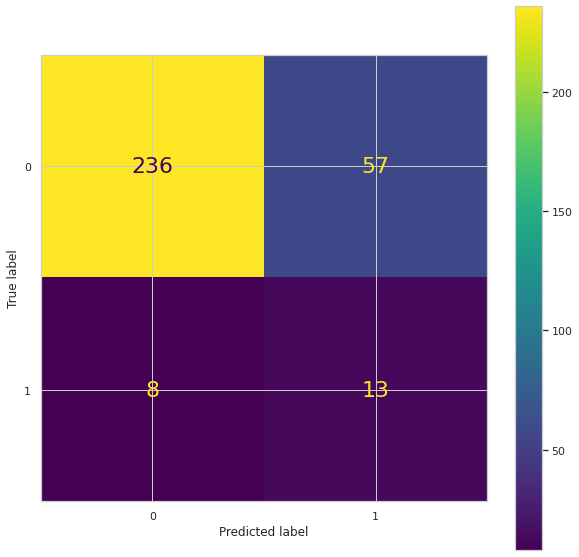

In [49]:
X_test_temp_scaled=pd.DataFrame(scaler.fit_transform(X_test_temp), columns=X_test_temp.columns)
# Plot confussion matrix
plt.rcParams['figure.figsize'] = (10, 10)
model_plot= SVC(kernel='poly',gamma=0.01,C=1000,degree=2) 
model_plot.fit(X_train_temp_scaled,y_train_temp)
y_pred_plot= model_plot.predict(X_test_temp_scaled)

cm_p = confusion_matrix(y_test, y_pred_plot)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_p)#,display_labels=model_plot.classes_)
plt.rcParams.update( {'font.size': 22})
disp.plot()
plt.show()


## Appendix

### bayson optimization and visualion

In [ ]:
mcc_bay=make_scorer(mcc_score,greater_is_better=True)
SCORING_METRIC = mcc_bay
pipe = Pipeline([
    ('model', SVC())
])
linsvc_bsearch = {
    'model': [LinearSVC(max_iter=1000)],
    'model__C': (1e-1, 1e+4, 'log-uniform'),
}
svc_bsearch = {
    'model': Categorical([SVC()]),
    'model__C': Real(1e-1, 1e+4, prior='log-uniform'),
    'model__gamma': Real(1e-4, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1,8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

bay = BayesSearchCV(pipe,[(svc_bsearch, 40), (linsvc_bsearch, 16)] , cv=cv, scoring=SCORING_METRIC)

bay.fit(X_train_temp_scaled, y_train_temp)

bay.optimizer_results_

### plot bayson optimiser

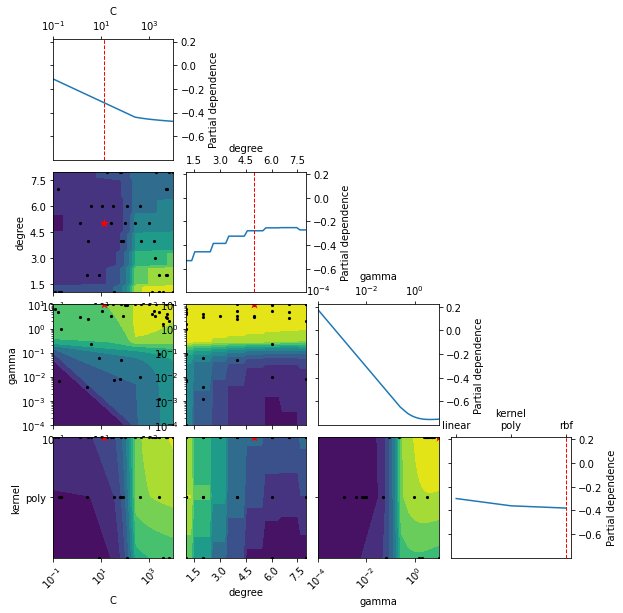

In [174]:
_ = plot_objective(bay.optimizer_results_[0],
                   dimensions=["C", "degree", "gamma", "kernel"],
                   n_minimum_search=int(1e8))
plt.show()

In [170]:
def svm_b(X_train, y_train, X_test, y_test):
    scaler=MinMaxScaler()
    X_train_scaled= pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled= pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
    #model =SVC(kernel='linear',C=1000) # scoring = recall,  , accuracy, AUC ROC , refit ='auc roc' 
    #model=SVC(kernel='rbf',gamma=0.001,C=1)  # scoring = recall, precision , AUC_ROC , refit ='recall' df_svm1 [1], grid_tune1 = GridSearchCV(SVC(), param_grid=tuned_parameters, cv=cv, scoring= 'recall',verbose=4,refit='roc_auc')
    #model= SVC(kernel='poly',C=0.1,gamma=0.1) # when param grid was used 50 combination enede up , no degree was provided
    #model= SVC(kernel='rbf',gamma=0.001,C=1)
    #model= SVC(kernel='rbf',gamma=10,C=1) # scorer has all parameters , rec, pre, f1, fbeta, roc , refit is fbeta
    #after heatmap
    #10000,0.1
    #10000,0.01
    #100,1
    #1000,1
   # model= SVC(kernel='rbf',gamma=0.01,C=10000) # scorer has all parameters , rec, pre, f1, fbeta, roc , refit is fbeta
    # from notebook on svm 
    #param_model               SVC(C=285.7161283992446, degree=5, gamma=10.0)

    model= SVC(kernel='rbf',gamma=10,C=13.18,degree=5) # scorer has all parameters , rec, pre, f1, fbeta, roc , refit is fbeta
    
    model.fit(X_train_scaled,y_train)


    #For TEST SPLIT
    y_pred= model.predict(X_test_scaled)
    cf_matrix = confusion_matrix(y_test, y_pred)
    accuracy= accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred) ##
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = cf_matrix[1][1] / ( cf_matrix[1][1] + cf_matrix[1][0] )
    auc = roc_auc_score(y_test, y_pred)
    type_1_error_FP = cf_matrix[0][1]
    type_2_error_FN = cf_matrix[1][0]
    log_loss_ = log_loss(y_test, y_pred)
    cohen_kappa_score_ = cohen_kappa_score(y_test, y_pred)
    mcc= matthews_corrcoef(y_test, y_pred)
    #Note by default 1 is the positive label. Therefore, -1 is negative
    #bad waffe -> 2 line of matrix -> POSITIVE -> data = -1

    #For TRAIN SPLIT
    y_pred_train= model.predict(X_train_scaled)
    cf_matrix_train = confusion_matrix(y_train, y_pred_train)
    accuracy_train= accuracy_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train) ##
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    specificity_train = cf_matrix_train[1][1] / ( cf_matrix_train[1][1] + cf_matrix_train[1][0] )
    auc_train = roc_auc_score(y_train, y_pred_train)
    type_1_error_FP_train = cf_matrix_train[0][1]
    type_2_error_FN_train = cf_matrix_train[1][0]
    mcc_train= matthews_corrcoef(y_train, y_pred_train)




    return cf_matrix, accuracy, f1, precision, recall, mcc, type_1_error_FP, type_2_error_FN, auc,log_loss_,cohen_kappa_score_, cf_matrix_train, accuracy_train, f1_train, precision_train, recall_train, mcc_train, type_1_error_FP_train, type_2_error_FN_train, auc_train


In [158]:
bay_result=[]

In [171]:
cf_matrix, accuracy, f1, precision, recall, mcc, type_1_error_FP, type_2_error_FN, auc, log_loss_,cohen_kappa_score_, cf_matrix_train, accuracy_train, f1_train, precision_train, recall_train, mcc_train, type_1_error_FP_train, type_2_error_FN_train, auc_train = svm_b(X_train_temp, y_train_temp, X_test_temp, y_test_temp)
bay_result.append((cf_matrix, accuracy, f1, precision, recall, mcc, type_1_error_FP, type_2_error_FN, auc, log_loss_, cohen_kappa_score_, cf_matrix_train, accuracy_train, f1_train, precision_train, recall_train, mcc_train, type_1_error_FP_train, type_2_error_FN_train, auc_train))


In [172]:
df_bayc= pd.DataFrame(bay_result, columns = ['cf_matrix', 'accuracy', 'f1', 'precision', 'recall', 'mcc', 'type_1_error_FP', 'type_2_error_FN', 'auc', 'log_loss_','cohen_kappa_score_','cf_matrix_train', 'accuracy_train', 'f1_train', 'precision_train', 'recall_train', 'mcc_train', 'type_1_error_FP_train', 'type_2_error_FN_train', 'auc_train'])


In [173]:
df_bayc

,cf_matrix,accuracy,f1,precision,recall,mcc,type_1_error_FP,type_2_error_FN,auc,log_loss_,cohen_kappa_score_,cf_matrix_train,accuracy_train,f1_train,precision_train,recall_train,mcc_train,type_1_error_FP_train,type_2_error_FN_train,auc_train
0,"[[289, 4], [20, 1]]",0.923567,0.076923,0.2,0.047619,0.067786,4,20,0.516984,2.639917,0.052552,"[[755, 0], [0, 1018]]",1.0,1.0,1.0,1.0,1.0,0,0,1.0
1,"[[289, 4], [20, 1]]",0.923567,0.076923,0.2,0.047619,0.067786,4,20,0.516984,2.639917,0.052552,"[[755, 0], [0, 1018]]",1.0,1.0,1.0,1.0,1.0,0,0,1.0
2,"[[289, 4], [20, 1]]",0.923567,0.076923,0.2,0.047619,0.067786,4,20,0.516984,2.639917,0.052552,"[[755, 0], [0, 1018]]",1.0,1.0,1.0,1.0,1.0,0,0,1.0


## CV again in the end for confusion Matrix 

In [ ]:
np.random.seed(0) ; np.random.rand(4)
cv_again = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
model=SVC(kernel='poly',degree=2,gamma=0.01,C=10000) # best parameters after grid search 

scoring_cv = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'mcc_score' : make_scorer(mcc_score,greater_is_better=True)
           }

X_test_temp_scaled=pd.DataFrame(scaler.fit_transform(X_test_temp), columns=X_test_temp.columns)

cv_again = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
scores_cv= cross_validate(model, X_test_temp_scaled, y_test_temp, cv=cv_again, scoring=scoring_cv)
scores_cv_train = cross_validate(model, X_train_temp_scaled, y_train_temp, cv=cv_again, scoring=scoring_cv)

scores_cv

# scoring for CV with confusion matrix scorer

scores_cf= cross_validate(model, X_test_temp_scaled, y_test_temp, cv=cv_again, scoring=confusion_matrix_scorer)

scores_cf

print("Accuracy (Testing):  %0.4f (+/- %0.4f)" % (scores_cv['test_accuracy'].mean(), scores_cv['test_accuracy'].std() * 2))
print("Precision (Testing):  %0.4f (+/- %0.4f)" % (scores_cv['test_precision'].mean(), scores_cv['test_precision'].std() * 2))
print("Recall (Testing):  %0.4f (+/- %0.4f)" % (scores_cv['test_recall'].mean(), scores_cv['test_recall'].std() * 2))
print("F1-Score (Testing):  %0.4f (+/- %0.4f)" % (scores_cv['test_f1_score'].mean(), scores_cv['test_f1_score'].std() * 2))
print("MCC-Score (Testing):  %0.4f (+/- %0.4f)" % (scores_cv['test_f1_score'].mean(), scores_cv['test_f1_score'].std() * 2))

## large number of HP with 10 fold CV

In [ ]:
scorer_hp={#'cf_scorer': make_scorer(confusion_matrix_scorer),
        'acc' : 'accuracy',
        'rec' : 'recall',
        'pre': 'precision',
        'f1' : 'f1',
        #'fbeta' : make_scorer(fbeta_score, beta=3),
        'mcc' : make_scorer(mcc_score,greater_is_better=True),
        'roc' :'roc_auc',
        'tpr' : make_scorer(tpr_score,greater_is_better=True),
        'fpr' : make_scorer(fpr_score,greater_is_better=False),
        'cost' : make_scorer(cost_wafer,greater_is_better=False)
         }
#grid_tune=grid = GridSearchCV(SVC(), param_grid=tuned_parameters, cv=cv, scoring= ['recall','accuracy','roc_auc'],verbose=4,refit='roc_auc')
cv_hp = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
#grid_tune1 = GridSearchCV(SVC(), param_grid=tuned_parameters, cv=cv, scoring='accuracy' ,refit='recall',verbose=4)
grid_hp= GridSearchCV(SVC(), param_grid=hp, cv=cv_hp, scoring=scorer_hp ,refit='mcc',verbose=4, return_train_score=True)
#grid = GridSearchCV(SVC(), param_grid=param_test, cv=cv, scoring=scorer ,refit='roc',verbose=4,error_score="raise")
grid_hp.fit(X_train_temp_scaled, y_train_temp)
pd.DataFrame.from_dict(grid.cv_results_).shape

# Appendix from 2nd ppt

# PART 2: EXECUTION

In [21]:
fast_track_cols = X_test.columns
fast_track_cols.shape

(466,)

In [18]:
X = read_features()
y = read_target().iloc[:,0]

removing_coli = 'No'
#['Yes', 'No']

result = []
i = 1



#step 1:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify=y)
#change random state??

#-----------

# # step 2:
X_train = remove_duplicated_columns(X_train)
# #step 3:
X_train = remove_constant_volatility(X_train)
# #step 4:
X_train = remove_cols_with_high_pct_null(X_train, 0.8) #this can be in the loop too, may be later
# #step 5: remove the same columns from step 2-4 TRAIN_TEST split
X_test = X_test.loc[:,X_train.columns]

#------------
fast_track_cols = X_test.columns

X_train = X_train.loc[:, fast_track_cols]
X_test = X_test.loc[:, fast_track_cols]

#------------




#step 6-9
replace_outlier_options = ['3s'] #nothing at all
#replace_outlier_options = ['3s','NaN','nothing']
impute_null_options = ['knn__distance']
#impute_null_options = ['knn__distance', 'MICE', 'knn__uniform']
FS_options = ['BoS__shap']
#FS_options = ['BoP','BoS__shap', 'BoS__gini', 'RFE__RF', 'RFE__SVM', 'nothing]
sampling_options = ['SMOTEENN'] #TRY OTHER SAMPLING
#sampling_options = ['SMOTE','ROSE','ADASYN','SMOTEENN']
model_options = ['RF']
#model_options = ['LR', 'RF', 'NN']
#try RF=10depth

#next: TRY KNN DISTANCE

for replace_with in replace_outlier_options:
    for knn_weight in impute_null_options:
        for classifier_model in FS_options:
            for sampling_technique in sampling_options:
                for Model in model_options:
                    X_train_temp = X_train
                    X_test_temp = X_test
                    y_train_temp = y_train
                    y_test_temp = y_test

                    combined_technique = replace_with +' & '+ knn_weight +' & '+ classifier_model + ' & ' + removing_coli +' & '+ sampling_technique +' & '+ Model

                    #step 6: oulier treatement (on both TRAIN & TEST split)
                    if replace_with != 'nothing':
                        X_train_temp = replace_outlier(X_train_temp, replace_with)
                        X_test_temp = replace_outlier(X_test_temp, replace_with)
                    
                    #step 7: missing value imputation (on both TRAIN & TEST split)
                    if knn_weight == 'knn__distance' or knn_weight == 'knn__uniform':
                        X_train_temp, X_test_temp = impute_null_with_knn(X_train_temp, X_test_temp, knn_weight[-(len(knn_weight)-5):])
                    elif knn_weight == 'MICE':
                        X_train_temp, X_test_temp = impute_null_with_mice(X_train_temp, X_test_temp)

                    #step 8: feature selection (on both TRAIN & TEST split)
                    if classifier_model !='nothing':
                        if classifier_model == 'BoS__shap' or classifier_model == 'BoS__gini':
                            X_train_temp = BorutaShap_FS(X_train_temp, y_train_temp, classifier_model[-(len(classifier_model)-5):])
                        elif classifier_model == 'RFE__RF' or classifier_model == 'RFE__SVM':
                            X_train_temp = RFE_FS(X_train_temp, y_train_temp, classifier_model[-(len(classifier_model)-5):])
                        elif classifier_model == 'BoP':
                            X_train_temp = BorutaPy_FS(X_train_temp, y_train_temp)
                    

                        #step 9: remove multilinear features
                    if removing_coli=='Yes':
                        print('n_cols BEFORE multicolinearity treatement', X_train_temp.shape[1])
                        X_train_temp = remove_collinear_features(X_train_temp, 0.7)
                        print('n_cols AFTER multicolinearity treatement', X_train_temp.shape[1])

                    #apply the same result for TEST
                    X_test_temp = X_test_temp.loc[:,X_train_temp.columns]

                    #print out datasets for backup
                    #X_train_temp.to_csv('sampling_visualization/X_train_temp_BEFORESAMPLING_'+str(i)+combined_technique+'.csv')
                    #X_test_temp.to_csv('sampling_visualization/X_test_temp_BEFORESAMPLING_'+str(i)+combined_technique+'.csv')
                    #y_train_temp.to_csv('sampling_visualization/y_train_temp_BEFORESAMPLING_'+str(i)+combined_technique+'.csv')
                    #y_test_temp.to_csv('sampling_visualization/y_test_temp_BEFORESAMPLING_'+str(i)+combined_technique+'.csv')

                    #step 10: balancing only on TRAIN split
                    X_train_temp, y_train_temp = sampling(X_train_temp, y_train_temp, sampling_technique)

                    #print out datasets for backup
                    #X_train_temp.to_csv('sampling_visualization/X_train_temp_AFTERSAMPLING_'+str(i)+combined_technique+'.csv')
                    #X_test_temp.to_csv('sampling_visualization/X_test_temp_AFTERSAMPLING_'+str(i)+combined_technique+'.csv')
                    #y_train_temp.to_csv('sampling_visualization/y_train_temp_AFTERSAMPLING_'+str(i)+combined_technique+'.csv')
                    #y_test_temp.to_csv('sampling_visualization/y_test_temp_AFTERSAMPLING_'+str(i)+combined_technique+'.csv')


                    #step 11: train model, predict, and print scores
                    if Model != 'NN':
                        try:
                            cf_matrix, accuracy, f1, precision, recall, sensitivity, type_1_error_FP, type_2_error_FN, auc, log_loss_,cohen_kappa_score_, cf_matrix_train, accuracy_train, f1_train, precision_train, recall_train, sensitivity_train, type_1_error_FP_train, type_2_error_FN_train, auc_train = run_model(X_train_temp, y_train_temp, X_test_temp, y_test_temp, Model)
                        except Exception:
                            cf_matrix = accuracy = f1 = precision = recall = sensitivity = type_1_error_FP = type_2_error_FN = auc = log_loss_ =cohen_kappa_score_ = cf_matrix_train = accuracy_train = f1_train = precision_train = recall_train = sensitivity_train = type_1_error_FP_train = type_2_error_FN_train = auc_train = 0
                    #elif Model == 'NN':
                    #    try:
                    #        cf_matrix, accuracy, f1, precision, recall, sensitivity, type_1_error_FP, type_2_error_FN, auc, log_loss_,cohen_kappa_score_, cf_matrix_train, accuracy_train, f1_train, precision_train, recall_train, sensitivity_train, type_1_error_FP_train, type_2_error_FN_train, auc_train = run_model_NN(X_train_temp, y_train_temp, X_test_temp, y_test_temp)
                    #    except Exception:
                    #        cf_matrix = accuracy = f1 = precision = recall = sensitivity = type_1_error_FP = type_2_error_FN = auc = log_loss_ =cohen_kappa_score_ = cf_matrix_train = accuracy_train = f1_train = precision_train = recall_train = sensitivity_train = type_1_error_FP_train = type_2_error_FN_train = auc_train = 0

                    result.append((i, combined_technique, X_train_temp.shape[1], replace_with, knn_weight, classifier_model, removing_coli, sampling_technique, Model, X_train_temp.columns, cf_matrix, accuracy, f1, precision, recall, sensitivity, type_1_error_FP, type_2_error_FN, auc, log_loss_, cohen_kappa_score_, cf_matrix_train, accuracy_train, f1_train, precision_train, recall_train, sensitivity_train, type_1_error_FP_train, type_2_error_FN_train, auc_train))
                    
                    print('attemp no.: ',i, combined_technique,' acc: ', accuracy,' accuracy_train: ',accuracy_train, ' f1: ', f1,' f1_train: ',f1_train, ' sensitivity: ', sensitivity, ' :auc ', auc, ' cfm: ', '\n', cf_matrix, '\n n_cols', X_train_temp.shape[1])
                    

                    if i%5==0: 
                        df_result = pd.DataFrame(result, columns = ['No.','combination','n_cols','outlier_replace_with', 'imputation_knn_weight', 'FS_classifier_model', 'removing_coli','balancing_sampling_technique', 'Model','cols','cf_matrix', 'accuracy', 'f1', 'precision', 'recall', 'sensitivity', 'type_1_error_FP', 'type_2_error_FN', 'auc', 'log_loss_','cohen_kappa_score_','cf_matrix_train', 'accuracy_train', 'f1_train', 'precision_train', 'recall_train', 'sensitivity_train', 'type_1_error_FP_train', 'type_2_error_FN_train', 'auc_train'])
                        #df_result.to_csv('tracker/result'+str(i)+'.csv')
                    

                    i+=1



df_result = pd.DataFrame(result, columns = ['No.','combination','n_cols','outlier_replace_with', 'imputation_knn_weight', 'FS_classifier_model', 'removing_coli','balancing_sampling_technique', 'Model','cols','cf_matrix', 'accuracy', 'f1', 'precision', 'recall', 'sensitivity', 'type_1_error_FP', 'type_2_error_FN', 'auc', 'log_loss_','cohen_kappa_score_','cf_matrix_train', 'accuracy_train', 'f1_train', 'precision_train', 'recall_train', 'sensitivity_train', 'type_1_error_FP_train', 'type_2_error_FN_train', 'auc_train'])
#df_result.to_csv('tracker/bm.csv')



100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


attemp no.:  1 3s & knn__distance & BoS__shap & No & SMOTEENN & RF  acc:  0.7197452229299363  accuracy_train:  0.9142695995487874  f1:  0.25423728813559326  f1_train:  0.9285042333019755  sensitivity:  0.7142857142857143  :auc  0.7172111165285228  cfm:  
 [[211  82]
 [  6  15]] 
 n_cols 19


In [23]:
df_3pt= df_result.loc[:,['cf_matrix', 'accuracy', 'f1', 'precision', 'recall', 'sensitivity', 'type_1_error_FP', 'type_2_error_FN', 'auc','cf_matrix_train', 'accuracy_train', 'f1_train', 'precision_train', 'recall_train', 'sensitivity_train', 'type_1_error_FP_train', 'type_2_error_FN_train', 'auc_train']]

In [24]:
df_3pt

,cf_matrix,accuracy,f1,precision,recall,sensitivity,type_1_error_FP,type_2_error_FN,auc,cf_matrix_train,accuracy_train,f1_train,precision_train,recall_train,sensitivity_train,type_1_error_FP_train,type_2_error_FN_train,auc_train
0,"[[211, 82], [6, 15]]",0.719745,0.254237,0.154639,0.714286,0.714286,6,82,0.717211,"[[634, 121], [31, 987]]",0.91427,0.928504,0.890794,0.969548,0.969548,31,121,0.904642
